In [1]:
pip install numpy==1.26.4 torch transformers==4.48.2 scikit-learn accelerate==0.26.0 matplotlib tqdm pandas seaborn

Note: you may need to restart the kernel to use updated packages.


In [8]:
# encoder_only_kfold_debug.py – versi siap inference (updated)
# Menyimpan best_model.pt, model_config.json, vocab.txt, confusion_fold.png,
# final_summary_perkelas.csv, dan final_summary_best_only.csv (1 fold terbaik saja)

import os, glob, gc, copy, math, random, time, json
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from tqdm import tqdm

# ════════════════ KONFIGURASI ════════════════════════════
DATA_DIR    = "/workspace/SPLIT_BEATS_NPY/train"
LABEL_MAP   = {'N':0,'L':1,'R':2,'V':3,'Q':4}
SEED        = 42
N_SPLITS    = 5
EPOCHS      = 20
BATCH_SIZE  = 32
MAX_LEN     = 512
EMB_DIM     = 512
N_HEADS     = 8
FF_DIM      = 2048
N_LAYERS    = 12
LR          = 2e-5
OUTPUT_BASE = "/workspace/HASIL_ENCODER/HASIL_4"
os.makedirs(OUTPUT_BASE, exist_ok=True)

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PAD_ID, CLS_ID  = 256, 257
VOCAB_SIZE      = 258
cls_names       = list(LABEL_MAP.keys())

# ══════════════ UTILITAS ════════════════════════════

def signal_to_ids(sig: np.ndarray):
    norm = ((sig - sig.min()) / (sig.ptp() + 1e-8) * 255).astype(int)
    ids  = np.concatenate(([CLS_ID], norm))[:MAX_LEN]
    mask = np.ones_like(ids, dtype=int)
    if len(ids) < MAX_LEN:
        pad_len = MAX_LEN - len(ids)
        ids  = np.concatenate((ids,  np.full(pad_len, PAD_ID,  dtype=int)))
        mask = np.concatenate((mask, np.zeros(pad_len,       dtype=int)))
    return ids, mask

# ══════════════ MUAT DATA ════════════════════════════
files, labels = [], []
for cls, idx in LABEL_MAP.items():
    for f in glob.glob(os.path.join(DATA_DIR, cls, "*.npy")):
        files.append(f); labels.append(idx)
files, labels = np.array(files), np.array(labels)

print("Pre‑encoding semua sampel …")
all_ids, all_mask = [], []
for f in tqdm(files, total=len(files)):
    ids, msk = signal_to_ids(np.load(f))
    all_ids.append(ids);  all_mask.append(msk)
all_ids  = torch.tensor(all_ids,  dtype=torch.long)
all_mask = torch.tensor(all_mask, dtype=torch.long)
labels_t = torch.tensor(labels,   dtype=torch.long)

# ══════════════ DEFINISI MODEL ══════════════════════════
class EncoderOnlyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_emb = nn.Embedding(VOCAB_SIZE, EMB_DIM, padding_idx=PAD_ID)
        self.pos_emb   = nn.Parameter(torch.zeros(1, MAX_LEN, EMB_DIM))
        enc_layer = nn.TransformerEncoderLayer(d_model=EMB_DIM, nhead=N_HEADS, dim_feedforward=FF_DIM, dropout=0.1, batch_first=True)
        self.encoder  = nn.TransformerEncoder(enc_layer, num_layers=N_LAYERS)
        self.fc       = nn.Linear(EMB_DIM, len(LABEL_MAP))
        nn.init.normal_(self.pos_emb, std=0.02)

    def forward(self, input_ids, attention_mask):
        x = self.token_emb(input_ids) + self.pos_emb
        x = self.encoder(x, src_key_padding_mask=~attention_mask.bool())
        x = (x * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True).clamp(min=1e-9)
        return self.fc(x)

# ══════════════ K‑FOLD TRAINING ══════════════════════════
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
rows_all = []
fold_val_losses = []

for fold, (tr, va) in enumerate(skf.split(all_ids, labels), 1):
    print(f"\n════ FOLD {fold}/{N_SPLITS} ════")
    gc.collect(); torch.cuda.empty_cache()

    train_ds = TensorDataset(all_ids[tr], all_mask[tr], labels_t[tr])
    val_ds   = TensorDataset(all_ids[va], all_mask[va], labels_t[va])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)

    model = EncoderOnlyClassifier().to(DEVICE)
    optim = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, EPOCHS)

    best_state, best_loss = None, math.inf
    out_dir = os.path.join(OUTPUT_BASE, f"fold{fold}"); os.makedirs(out_dir, exist_ok=True)

    for epoch in range(1, EPOCHS + 1):
        start_t = time.time(); model.train(); tot_loss = 0
        print(f"\U0001f300 Fold {fold} | Epoch {epoch}/{EPOCHS}")
        for ids, msk, lbl in tqdm(train_loader, leave=False):
            ids, msk, lbl = ids.to(DEVICE), msk.to(DEVICE), lbl.to(DEVICE)
            optim.zero_grad(); loss = F.cross_entropy(model(ids, msk), lbl)
            loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0); optim.step()
            tot_loss += loss.item()
        scheduler.step()
        print(f"✅ Fold {fold} | Epoch {epoch} done | TrainLoss={tot_loss/len(train_loader):.4f} | Time={time.time()-start_t:.1f}s")

        model.eval(); val_loss, preds, yh = 0, [], []
        with torch.no_grad():
            for ids, msk, lbl in val_loader:
                ids, msk, lbl = ids.to(DEVICE), msk.to(DEVICE), lbl.to(DEVICE)
                out = model(ids, msk)
                val_loss += F.cross_entropy(out, lbl, reduction='sum').item()
                preds.append(out.argmax(1).cpu()); yh.append(lbl.cpu())
        val_loss /= len(val_ds)
        preds = torch.cat(preds).numpy(); y_true = torch.cat(yh).numpy()
        print(f"📊  ValLoss={val_loss:.4f}")
        if val_loss < best_loss:
            best_loss, best_state = val_loss, copy.deepcopy(model.state_dict())

    torch.save(best_state, os.path.join(out_dir, "best_model.pt"))
    with open(os.path.join(out_dir, "model_config.json"), "w") as f:
        json.dump({"emb_dim":EMB_DIM,"n_layers":N_LAYERS,"n_heads":N_HEADS,"ff_dim":FF_DIM,"max_len":MAX_LEN,"vocab_size":VOCAB_SIZE,"pad_id":PAD_ID,"cls_id":CLS_ID,"label_map":LABEL_MAP}, f, indent=2)
    with open(os.path.join(out_dir, "vocab.txt"), "w") as f:
        f.writelines([f"{i}\n" for i in range(256)] + ["[PAD]\n","[CLS]\n"])

    model.load_state_dict(best_state); model.eval()
    with torch.no_grad():
        logits = []; y_true = []
        for ids, msk, lbl in val_loader:
            ids, msk = ids.to(DEVICE), msk.to(DEVICE)
            logits.append(model(ids, msk).cpu()); y_true.append(lbl)
    preds = torch.cat(logits).argmax(1).numpy(); y_true = torch.cat(y_true).numpy()

    cm = confusion_matrix(y_true, preds, labels=list(range(len(cls_names))))
    plt.figure(figsize=(7,6)); plt.imshow(cm, cmap='Blues'); plt.title(f"Confusion Fold {fold}")
    plt.xticks(range(len(cls_names)), cls_names); plt.yticks(range(len(cls_names)), cls_names)
    for r in range(len(cm)):
        for c in range(len(cm)):
            plt.text(c, r, cm[r,c], ha='center', va='center')
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "confusion_fold.png")); plt.close()

    fold_val_losses.append((fold, best_loss))
    for i, cls in enumerate(cls_names):
        TP = cm[i,i]; FN = cm[i].sum()-TP; FP = cm[:,i].sum()-TP; TN = cm.sum()-TP-FN-FP
        ACC  = (TP+TN)/cm.sum(); REC = TP/(TP+FN+1e-8); SPEC = TN/(TN+FP+1e-8); F1 = 2*TP/(2*TP+FP+FN+1e-8)
        rows_all.append({"fold": fold, "kelas": cls, "akurasi": round(ACC,4), "f1": round(F1,4), "recall": round(REC,4), "spesifisitas": round(SPEC,4)})

# Simpan metrik ke CSV akhir
out_df = pd.DataFrame(rows_all)
out_df.to_csv(os.path.join(OUTPUT_BASE, "final_summary_perkelas.csv"), index=False)

# Ambil hanya fold terbaik berdasarkan val_loss terendah
best_fold = sorted(fold_val_losses, key=lambda x: x[1])[0][0]
out_df[out_df.fold == best_fold].to_csv(os.path.join(OUTPUT_BASE, "final_summary_best_only.csv"), index=False)

Pre‑encoding semua sampel …


100%|██████████| 28000/28000 [00:03<00:00, 8194.32it/s]



════ FOLD 1/5 ════
🌀 Fold 1 | Epoch 1/20


✅ Fold 1 | Epoch 1 done | TrainLoss=0.8875 | Time=261.4s
📊  ValLoss=0.6863
🌀 Fold 1 | Epoch 2/20


✅ Fold 1 | Epoch 2 done | TrainLoss=0.5396 | Time=261.6s
📊  ValLoss=0.5823
🌀 Fold 1 | Epoch 3/20


✅ Fold 1 | Epoch 3 done | TrainLoss=0.4140 | Time=261.7s
📊  ValLoss=0.3920
🌀 Fold 1 | Epoch 4/20


✅ Fold 1 | Epoch 4 done | TrainLoss=0.3407 | Time=261.3s
📊  ValLoss=0.4125
🌀 Fold 1 | Epoch 5/20


✅ Fold 1 | Epoch 5 done | TrainLoss=0.2934 | Time=261.4s
📊  ValLoss=0.3479
🌀 Fold 1 | Epoch 6/20


✅ Fold 1 | Epoch 6 done | TrainLoss=0.2582 | Time=261.4s
📊  ValLoss=0.3550
🌀 Fold 1 | Epoch 7/20


✅ Fold 1 | Epoch 7 done | TrainLoss=0.2210 | Time=261.4s
📊  ValLoss=0.3040
🌀 Fold 1 | Epoch 8/20


✅ Fold 1 | Epoch 8 done | TrainLoss=0.1981 | Time=260.5s
📊  ValLoss=0.2857
🌀 Fold 1 | Epoch 9/20


✅ Fold 1 | Epoch 9 done | TrainLoss=0.1713 | Time=260.8s
📊  ValLoss=0.2702
🌀 Fold 1 | Epoch 10/20


✅ Fold 1 | Epoch 10 done | TrainLoss=0.1492 | Time=261.0s
📊  ValLoss=0.2610
🌀 Fold 1 | Epoch 11/20


✅ Fold 1 | Epoch 11 done | TrainLoss=0.1312 | Time=261.6s
📊  ValLoss=0.2506
🌀 Fold 1 | Epoch 12/20


✅ Fold 1 | Epoch 12 done | TrainLoss=0.1177 | Time=261.0s
📊  ValLoss=0.2205
🌀 Fold 1 | Epoch 13/20


✅ Fold 1 | Epoch 13 done | TrainLoss=0.0999 | Time=261.5s
📊  ValLoss=0.2196
🌀 Fold 1 | Epoch 14/20


✅ Fold 1 | Epoch 14 done | TrainLoss=0.0891 | Time=261.7s
📊  ValLoss=0.2403
🌀 Fold 1 | Epoch 15/20


✅ Fold 1 | Epoch 15 done | TrainLoss=0.0781 | Time=261.7s
📊  ValLoss=0.2395
🌀 Fold 1 | Epoch 16/20


✅ Fold 1 | Epoch 16 done | TrainLoss=0.0658 | Time=261.6s
📊  ValLoss=0.2295
🌀 Fold 1 | Epoch 17/20


✅ Fold 1 | Epoch 17 done | TrainLoss=0.0594 | Time=261.5s
📊  ValLoss=0.2339
🌀 Fold 1 | Epoch 18/20


✅ Fold 1 | Epoch 18 done | TrainLoss=0.0527 | Time=261.4s
📊  ValLoss=0.2415
🌀 Fold 1 | Epoch 19/20


✅ Fold 1 | Epoch 19 done | TrainLoss=0.0496 | Time=260.4s
📊  ValLoss=0.2366
🌀 Fold 1 | Epoch 20/20


✅ Fold 1 | Epoch 20 done | TrainLoss=0.0463 | Time=261.2s
📊  ValLoss=0.2374

════ FOLD 2/5 ════
🌀 Fold 2 | Epoch 1/20


✅ Fold 2 | Epoch 1 done | TrainLoss=0.9181 | Time=261.2s
📊  ValLoss=0.6789
🌀 Fold 2 | Epoch 2/20


✅ Fold 2 | Epoch 2 done | TrainLoss=0.5301 | Time=261.5s
📊  ValLoss=0.5187
🌀 Fold 2 | Epoch 3/20


✅ Fold 2 | Epoch 3 done | TrainLoss=0.3969 | Time=259.9s
📊  ValLoss=0.3665
🌀 Fold 2 | Epoch 4/20


✅ Fold 2 | Epoch 4 done | TrainLoss=0.3285 | Time=260.9s
📊  ValLoss=0.3188
🌀 Fold 2 | Epoch 5/20


✅ Fold 2 | Epoch 5 done | TrainLoss=0.2902 | Time=260.9s
📊  ValLoss=0.3285
🌀 Fold 2 | Epoch 6/20


✅ Fold 2 | Epoch 6 done | TrainLoss=0.2522 | Time=260.6s
📊  ValLoss=0.2975
🌀 Fold 2 | Epoch 7/20


✅ Fold 2 | Epoch 7 done | TrainLoss=0.2232 | Time=261.1s
📊  ValLoss=0.3084
🌀 Fold 2 | Epoch 8/20


✅ Fold 2 | Epoch 8 done | TrainLoss=0.1979 | Time=260.9s
📊  ValLoss=0.3087
🌀 Fold 2 | Epoch 9/20


✅ Fold 2 | Epoch 9 done | TrainLoss=0.1740 | Time=261.0s
📊  ValLoss=0.3282
🌀 Fold 2 | Epoch 10/20


✅ Fold 2 | Epoch 10 done | TrainLoss=0.1563 | Time=260.0s
📊  ValLoss=0.2362
🌀 Fold 2 | Epoch 11/20


✅ Fold 2 | Epoch 11 done | TrainLoss=0.1401 | Time=260.6s
📊  ValLoss=0.2292
🌀 Fold 2 | Epoch 12/20


✅ Fold 2 | Epoch 12 done | TrainLoss=0.1198 | Time=261.0s
📊  ValLoss=0.2540
🌀 Fold 2 | Epoch 13/20


✅ Fold 2 | Epoch 13 done | TrainLoss=0.1019 | Time=261.1s
📊  ValLoss=0.2236
🌀 Fold 2 | Epoch 14/20


✅ Fold 2 | Epoch 14 done | TrainLoss=0.0898 | Time=261.0s
📊  ValLoss=0.2144
🌀 Fold 2 | Epoch 15/20


✅ Fold 2 | Epoch 15 done | TrainLoss=0.0778 | Time=260.9s
📊  ValLoss=0.2177
🌀 Fold 2 | Epoch 16/20


✅ Fold 2 | Epoch 16 done | TrainLoss=0.0681 | Time=261.2s
📊  ValLoss=0.2312
🌀 Fold 2 | Epoch 17/20


✅ Fold 2 | Epoch 17 done | TrainLoss=0.0604 | Time=261.0s
📊  ValLoss=0.2171
🌀 Fold 2 | Epoch 18/20


✅ Fold 2 | Epoch 18 done | TrainLoss=0.0540 | Time=261.1s
📊  ValLoss=0.2247
🌀 Fold 2 | Epoch 19/20


✅ Fold 2 | Epoch 19 done | TrainLoss=0.0501 | Time=261.4s
📊  ValLoss=0.2234
🌀 Fold 2 | Epoch 20/20


✅ Fold 2 | Epoch 20 done | TrainLoss=0.0475 | Time=261.3s
📊  ValLoss=0.2231

════ FOLD 3/5 ════
🌀 Fold 3 | Epoch 1/20


✅ Fold 3 | Epoch 1 done | TrainLoss=0.8889 | Time=261.3s
📊  ValLoss=0.6173
🌀 Fold 3 | Epoch 2/20


✅ Fold 3 | Epoch 2 done | TrainLoss=0.5205 | Time=261.1s
📊  ValLoss=0.4370
🌀 Fold 3 | Epoch 3/20


✅ Fold 3 | Epoch 3 done | TrainLoss=0.3983 | Time=261.2s
📊  ValLoss=0.3986
🌀 Fold 3 | Epoch 4/20


✅ Fold 3 | Epoch 4 done | TrainLoss=0.3367 | Time=261.6s
📊  ValLoss=0.3832
🌀 Fold 3 | Epoch 5/20


✅ Fold 3 | Epoch 5 done | TrainLoss=0.2876 | Time=261.0s
📊  ValLoss=0.3383
🌀 Fold 3 | Epoch 6/20


✅ Fold 3 | Epoch 6 done | TrainLoss=0.2516 | Time=260.8s
📊  ValLoss=0.2832
🌀 Fold 3 | Epoch 7/20


✅ Fold 3 | Epoch 7 done | TrainLoss=0.2246 | Time=261.0s
📊  ValLoss=0.2453
🌀 Fold 3 | Epoch 8/20


✅ Fold 3 | Epoch 8 done | TrainLoss=0.1979 | Time=260.9s
📊  ValLoss=0.2348
🌀 Fold 3 | Epoch 9/20


✅ Fold 3 | Epoch 9 done | TrainLoss=0.1718 | Time=259.7s
📊  ValLoss=0.2532
🌀 Fold 3 | Epoch 10/20


✅ Fold 3 | Epoch 10 done | TrainLoss=0.1526 | Time=260.7s
📊  ValLoss=0.1986
🌀 Fold 3 | Epoch 11/20


✅ Fold 3 | Epoch 11 done | TrainLoss=0.1337 | Time=260.9s
📊  ValLoss=0.2080
🌀 Fold 3 | Epoch 12/20


✅ Fold 3 | Epoch 12 done | TrainLoss=0.1165 | Time=259.8s
📊  ValLoss=0.1962
🌀 Fold 3 | Epoch 13/20


✅ Fold 3 | Epoch 13 done | TrainLoss=0.1020 | Time=260.2s
📊  ValLoss=0.1863
🌀 Fold 3 | Epoch 14/20


✅ Fold 3 | Epoch 14 done | TrainLoss=0.0900 | Time=258.1s
📊  ValLoss=0.1885
🌀 Fold 3 | Epoch 15/20


✅ Fold 3 | Epoch 15 done | TrainLoss=0.0765 | Time=259.8s
📊  ValLoss=0.1936
🌀 Fold 3 | Epoch 16/20


✅ Fold 3 | Epoch 16 done | TrainLoss=0.0672 | Time=261.0s
📊  ValLoss=0.2014
🌀 Fold 3 | Epoch 17/20


✅ Fold 3 | Epoch 17 done | TrainLoss=0.0586 | Time=260.1s
📊  ValLoss=0.1948
🌀 Fold 3 | Epoch 18/20


✅ Fold 3 | Epoch 18 done | TrainLoss=0.0525 | Time=261.4s
📊  ValLoss=0.2021
🌀 Fold 3 | Epoch 19/20


✅ Fold 3 | Epoch 19 done | TrainLoss=0.0483 | Time=261.0s
📊  ValLoss=0.1963
🌀 Fold 3 | Epoch 20/20


✅ Fold 3 | Epoch 20 done | TrainLoss=0.0463 | Time=261.0s
📊  ValLoss=0.1946

════ FOLD 4/5 ════
🌀 Fold 4 | Epoch 1/20


✅ Fold 4 | Epoch 1 done | TrainLoss=0.8846 | Time=261.3s
📊  ValLoss=0.5519
🌀 Fold 4 | Epoch 2/20


✅ Fold 4 | Epoch 2 done | TrainLoss=0.5331 | Time=261.0s
📊  ValLoss=0.5639
🌀 Fold 4 | Epoch 3/20


✅ Fold 4 | Epoch 3 done | TrainLoss=0.3972 | Time=260.6s
📊  ValLoss=0.4148
🌀 Fold 4 | Epoch 4/20


✅ Fold 4 | Epoch 4 done | TrainLoss=0.3360 | Time=261.6s
📊  ValLoss=0.3111
🌀 Fold 4 | Epoch 5/20


✅ Fold 4 | Epoch 5 done | TrainLoss=0.2885 | Time=261.3s
📊  ValLoss=0.3057
🌀 Fold 4 | Epoch 6/20


✅ Fold 4 | Epoch 6 done | TrainLoss=0.2629 | Time=261.1s
📊  ValLoss=0.2766
🌀 Fold 4 | Epoch 7/20


✅ Fold 4 | Epoch 7 done | TrainLoss=0.2276 | Time=260.6s
📊  ValLoss=0.2749
🌀 Fold 4 | Epoch 8/20


✅ Fold 4 | Epoch 8 done | TrainLoss=0.1965 | Time=258.8s
📊  ValLoss=0.3321
🌀 Fold 4 | Epoch 9/20


✅ Fold 4 | Epoch 9 done | TrainLoss=0.1816 | Time=260.4s
📊  ValLoss=0.2654
🌀 Fold 4 | Epoch 10/20


✅ Fold 4 | Epoch 10 done | TrainLoss=0.1561 | Time=260.9s
📊  ValLoss=0.2342
🌀 Fold 4 | Epoch 11/20


✅ Fold 4 | Epoch 11 done | TrainLoss=0.1340 | Time=260.7s
📊  ValLoss=0.2431
🌀 Fold 4 | Epoch 12/20


✅ Fold 4 | Epoch 12 done | TrainLoss=0.1188 | Time=260.9s
📊  ValLoss=0.2015
🌀 Fold 4 | Epoch 13/20


✅ Fold 4 | Epoch 13 done | TrainLoss=0.1007 | Time=260.3s
📊  ValLoss=0.2067
🌀 Fold 4 | Epoch 14/20


✅ Fold 4 | Epoch 14 done | TrainLoss=0.0891 | Time=260.3s
📊  ValLoss=0.2109
🌀 Fold 4 | Epoch 15/20


✅ Fold 4 | Epoch 15 done | TrainLoss=0.0780 | Time=260.7s
📊  ValLoss=0.1873
🌀 Fold 4 | Epoch 16/20


✅ Fold 4 | Epoch 16 done | TrainLoss=0.0677 | Time=260.9s
📊  ValLoss=0.1920
🌀 Fold 4 | Epoch 17/20


✅ Fold 4 | Epoch 17 done | TrainLoss=0.0591 | Time=260.6s
📊  ValLoss=0.2011
🌀 Fold 4 | Epoch 18/20


✅ Fold 4 | Epoch 18 done | TrainLoss=0.0546 | Time=261.4s
📊  ValLoss=0.2006
🌀 Fold 4 | Epoch 19/20


✅ Fold 4 | Epoch 19 done | TrainLoss=0.0496 | Time=260.9s
📊  ValLoss=0.1996
🌀 Fold 4 | Epoch 20/20


✅ Fold 4 | Epoch 20 done | TrainLoss=0.0474 | Time=261.4s
📊  ValLoss=0.1969

════ FOLD 5/5 ════
🌀 Fold 5 | Epoch 1/20


✅ Fold 5 | Epoch 1 done | TrainLoss=0.8815 | Time=260.9s
📊  ValLoss=0.6597
🌀 Fold 5 | Epoch 2/20


✅ Fold 5 | Epoch 2 done | TrainLoss=0.5205 | Time=261.1s
📊  ValLoss=0.4242
🌀 Fold 5 | Epoch 3/20


✅ Fold 5 | Epoch 3 done | TrainLoss=0.4003 | Time=260.6s
📊  ValLoss=0.4276
🌀 Fold 5 | Epoch 4/20


✅ Fold 5 | Epoch 4 done | TrainLoss=0.3404 | Time=260.5s
📊  ValLoss=0.3641
🌀 Fold 5 | Epoch 5/20


✅ Fold 5 | Epoch 5 done | TrainLoss=0.2905 | Time=260.4s
📊  ValLoss=0.3418
🌀 Fold 5 | Epoch 6/20


✅ Fold 5 | Epoch 6 done | TrainLoss=0.2570 | Time=260.7s
📊  ValLoss=0.2628
🌀 Fold 5 | Epoch 7/20


✅ Fold 5 | Epoch 7 done | TrainLoss=0.2252 | Time=260.4s
📊  ValLoss=0.2931
🌀 Fold 5 | Epoch 8/20


✅ Fold 5 | Epoch 8 done | TrainLoss=0.2016 | Time=259.8s
📊  ValLoss=0.2767
🌀 Fold 5 | Epoch 9/20


✅ Fold 5 | Epoch 9 done | TrainLoss=0.1758 | Time=260.4s
📊  ValLoss=0.2296
🌀 Fold 5 | Epoch 10/20


✅ Fold 5 | Epoch 10 done | TrainLoss=0.1534 | Time=260.9s
📊  ValLoss=0.2341
🌀 Fold 5 | Epoch 11/20


✅ Fold 5 | Epoch 11 done | TrainLoss=0.1362 | Time=260.0s
📊  ValLoss=0.2365
🌀 Fold 5 | Epoch 12/20


✅ Fold 5 | Epoch 12 done | TrainLoss=0.1160 | Time=260.5s
📊  ValLoss=0.2477
🌀 Fold 5 | Epoch 13/20


✅ Fold 5 | Epoch 13 done | TrainLoss=0.1018 | Time=260.6s
📊  ValLoss=0.2228
🌀 Fold 5 | Epoch 14/20


✅ Fold 5 | Epoch 14 done | TrainLoss=0.0866 | Time=260.6s
📊  ValLoss=0.2109
🌀 Fold 5 | Epoch 15/20


✅ Fold 5 | Epoch 15 done | TrainLoss=0.0736 | Time=260.4s
📊  ValLoss=0.2278
🌀 Fold 5 | Epoch 16/20


✅ Fold 5 | Epoch 16 done | TrainLoss=0.0642 | Time=260.3s
📊  ValLoss=0.2300
🌀 Fold 5 | Epoch 17/20


✅ Fold 5 | Epoch 17 done | TrainLoss=0.0586 | Time=260.7s
📊  ValLoss=0.2132
🌀 Fold 5 | Epoch 18/20


✅ Fold 5 | Epoch 18 done | TrainLoss=0.0511 | Time=261.0s
📊  ValLoss=0.2215
🌀 Fold 5 | Epoch 19/20


✅ Fold 5 | Epoch 19 done | TrainLoss=0.0481 | Time=260.3s
📊  ValLoss=0.2187
🌀 Fold 5 | Epoch 20/20


✅ Fold 5 | Epoch 20 done | TrainLoss=0.0461 | Time=260.7s
📊  ValLoss=0.2196


In [ ]:
import os, json, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import pandas as pd
from tqdm import tqdm

# === CONFIG ===
MODEL_PATH   = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_TRAIN\BEATS\HASIL_DECODER\HASIL_2\fold4\best_model.pt"
CONFIG_PATH  = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_TRAIN\BEATS\HASIL_DECODER\HASIL_2\fold4\model_config.json"
TEST_DIR     = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\DATA\output_coba\SPLIT_BEATS_NPY\Beats_TEST"
OUTPUT_DIR   = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_AKHIR_RECORD\BEATS\EVALUASI_DECODER_TEST"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Load config ===
with open(CONFIG_PATH) as f:
    config = json.load(f)

PAD_ID = config["pad_id"]
CLS_ID = config["cls_id"]
LABEL_MAP = config["label_map"]
IDX2LABEL = {v: k for k, v in LABEL_MAP.items()}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Define Decoder-Only Model ===
class DecoderOnlyClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config["vocab_size"], config["emb_dim"], padding_idx=PAD_ID)
        self.pos_emb = nn.Parameter(torch.randn(1, config["max_len"], config["emb_dim"]))
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=config["emb_dim"],
            nhead=config["n_heads"],
            dim_feedforward=config["ff_dim"],
            dropout=0.1,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=config["n_layers"])
        self.fc = nn.Linear(config["emb_dim"], len(config["label_map"]))

    def forward(self, input_ids, attention_mask):
        x = self.token_emb(input_ids) + self.pos_emb[:, :input_ids.size(1), :]
        memory = x.clone()
        x = self.decoder(tgt=x, memory=memory, tgt_key_padding_mask=~attention_mask.bool())
        x = (x * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True).clamp(min=1e-9)
        return self.fc(x)

# === Load Model ===
model = DecoderOnlyClassifier(config).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# === Data Loader ===
def signal_to_ids(sig):
    norm = ((sig - sig.min()) / (sig.ptp() + 1e-8)) * 255
    ids = [CLS_ID] + norm.astype(int).tolist()[:config["max_len"] - 1]
    mask = [1] * len(ids)
    if len(ids) < config["max_len"]:
        pad_len = config["max_len"] - len(ids)
        ids += [PAD_ID] * pad_len
        mask += [0] * pad_len
    return torch.tensor(ids), torch.tensor(mask)

X, M, Y = [], [], []
for label in os.listdir(TEST_DIR):
    label_path = os.path.join(TEST_DIR, label)
    if not os.path.isdir(label_path): continue
    for fname in os.listdir(label_path):
        fpath = os.path.join(label_path, fname)
        try:
            sig = np.load(fpath)
            ids, msk = signal_to_ids(sig)
            X.append(ids); M.append(msk); Y.append(LABEL_MAP[label])
        except:
            print(f"[WARNING] Failed to load {fpath}")

X = torch.stack(X)
M = torch.stack(M)
Y = torch.tensor(Y)

# === Inference ===
BATCH_SIZE = 64
y_pred, y_true = [], []
with torch.no_grad():
    for i in tqdm(range(0, len(X), BATCH_SIZE)):
        xb = X[i:i+BATCH_SIZE].to(DEVICE)
        mb = M[i:i+BATCH_SIZE].to(DEVICE)
        logits = model(xb, mb)
        pred = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred.extend(pred)
        y_true.extend(Y[i:i+BATCH_SIZE].numpy())

# === Evaluation ===
acc = accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, average='macro')
f1  = f1_score(y_true, y_pred, average='macro')
cm  = confusion_matrix(y_true, y_pred, labels=list(IDX2LABEL.keys()))

# === Save Confusion Matrix ===
plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - TEST SET")
plt.xticks(ticks=range(len(IDX2LABEL)), labels=IDX2LABEL.values())
plt.yticks(ticks=range(len(IDX2LABEL)), labels=IDX2LABEL.values())
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_test.png"))
plt.close()

# === Save CSV Metrics Per Kelas ===
rows = []
for i, label in IDX2LABEL.items():
    TP = cm[i,i]
    FN = cm[i].sum() - TP
    FP = cm[:,i].sum() - TP
    TN = cm.sum() - TP - FN - FP
    acc_cls  = (TP + TN) / cm.sum()
    rec_cls  = TP / (TP + FN + 1e-8)
    spec_cls = TN / (TN + FP + 1e-8)
    f1_cls   = 2 * TP / (2 * TP + FP + FN + 1e-8)
    rows.append({
        "kelas": label,
        "akurasi": round(acc_cls, 4),
        "recall": round(rec_cls, 4),
        "f1": round(f1_cls, 4),
        "spesifisitas": round(spec_cls, 4)
    })
df = pd.DataFrame(rows)
df.to_csv(os.path.join(OUTPUT_DIR, "summary_test_metrics.csv"), index=False)

print("✅ Evaluasi selesai. Hasil disimpan di:", OUTPUT_DIR)


100%|██████████| 110/110 [06:56<00:00,  3.79s/it]


✅ Evaluasi selesai. Hasil disimpan di: D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_AKHIR_RECORD\BEATS\EVALUASI_DECODER_TEST


In [4]:
import os, json, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import pandas as pd
from tqdm import tqdm

# === KONFIGURASI ===
MODEL_PATH   = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_TRAIN\BEATS\HASIL_ENCODER\HASIL_4\fold4\best_model.pt"
CONFIG_PATH  = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_TRAIN\BEATS\HASIL_ENCODER\HASIL_4\fold4\model_config.json"
TEST_DIR     = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\DATA\output_coba\SPLIT_BEATS_NPY\Beats_TEST"
OUTPUT_DIR   = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_AKHIR_RECORD\BEATS\EVALUASI_ENCODER_TEST"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Load config ===
with open(CONFIG_PATH) as f:
    config = json.load(f)

PAD_ID = config["pad_id"]
CLS_ID = config["cls_id"]
LABEL_MAP = config["label_map"]
IDX2LABEL = {v: k for k, v in LABEL_MAP.items()}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Definisi Model Encoder ===
class EncoderOnlyClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config["vocab_size"], config["emb_dim"], padding_idx=PAD_ID)
        self.pos_emb   = nn.Parameter(torch.zeros(1, config["max_len"], config["emb_dim"]))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config["emb_dim"],
            nhead=config["n_heads"],
            dim_feedforward=config["ff_dim"],
            dropout=0.1,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=config["n_layers"])
        self.fc = nn.Linear(config["emb_dim"], len(config["label_map"]))
        nn.init.normal_(self.pos_emb, std=0.02)

    def forward(self, input_ids, attention_mask):
        x = self.token_emb(input_ids) + self.pos_emb
        x = self.encoder(x, src_key_padding_mask=~attention_mask.bool())
        x = (x * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True).clamp(min=1e-8)
        return self.fc(x)

# === Load Model ===
model = EncoderOnlyClassifier(config).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# === Fungsi Preprocessing Sinyal ===
def signal_to_ids(sig):
    norm = ((sig - sig.min()) / (sig.ptp() + 1e-8)) * 255
    ids = [CLS_ID] + norm.astype(int).tolist()[:config["max_len"] - 1]
    mask = [1] * len(ids)
    if len(ids) < config["max_len"]:
        pad_len = config["max_len"] - len(ids)
        ids += [PAD_ID] * pad_len
        mask += [0] * pad_len
    return torch.tensor(ids), torch.tensor(mask)

# === Load Data Test ===
X, M, Y = [], [], []
for label in os.listdir(TEST_DIR):
    label_path = os.path.join(TEST_DIR, label)
    if not os.path.isdir(label_path): continue
    for fname in os.listdir(label_path):
        fpath = os.path.join(label_path, fname)
        try:
            sig = np.load(fpath)
            ids, msk = signal_to_ids(sig)
            X.append(ids); M.append(msk); Y.append(LABEL_MAP[label])
        except:
            print(f"[WARNING] Failed to load {fpath}")

X = torch.stack(X)
M = torch.stack(M)
Y = torch.tensor(Y)

# === Inference ===
BATCH_SIZE = 64
y_pred, y_true = [], []
with torch.no_grad():
    for i in tqdm(range(0, len(X), BATCH_SIZE)):
        xb = X[i:i+BATCH_SIZE].to(DEVICE)
        mb = M[i:i+BATCH_SIZE].to(DEVICE)
        logits = model(xb, mb)
        pred = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred.extend(pred)
        y_true.extend(Y[i:i+BATCH_SIZE].numpy())

# === Evaluasi Keseluruhan ===
acc = accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, average='macro')
f1  = f1_score(y_true, y_pred, average='macro')
cm  = confusion_matrix(y_true, y_pred, labels=list(IDX2LABEL.keys()))

# === Simpan Confusion Matrix PNG ===
plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - TEST SET (Encoder)")
plt.xticks(ticks=range(len(IDX2LABEL)), labels=IDX2LABEL.values())
plt.yticks(ticks=range(len(IDX2LABEL)), labels=IDX2LABEL.values())
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_test_encoder.png"))
plt.close()

# === Simpan CSV Metrik Per Kelas ===
rows = []
for i, label in IDX2LABEL.items():
    TP = cm[i,i]
    FN = cm[i].sum() - TP
    FP = cm[:,i].sum() - TP
    TN = cm.sum() - TP - FN - FP
    acc_cls  = (TP + TN) / cm.sum()
    rec_cls  = TP / (TP + FN + 1e-8)
    spec_cls = TN / (TN + FP + 1e-8)
    f1_cls   = 2 * TP / (2 * TP + FP + FN + 1e-8)
    rows.append({
        "kelas": label,
        "akurasi": round(acc_cls, 4),
        "recall": round(rec_cls, 4),
        "f1": round(f1_cls, 4),
        "spesifisitas": round(spec_cls, 4)
    })
df = pd.DataFrame(rows)
df.to_csv(os.path.join(OUTPUT_DIR, "summary_test_metrics_encoder.csv"), index=False)

print("✅ Evaluasi ENCODER test selesai. Semua file disimpan di:", OUTPUT_DIR)


  0%|          | 0/110 [00:00<?, ?it/s]c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(
100%|██████████| 110/110 [06:13<00:00,  3.40s/it] 


✅ Evaluasi ENCODER test selesai. Semua file disimpan di: D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_AKHIR_RECORD\BEATS\EVALUASI_ENCODER_TEST


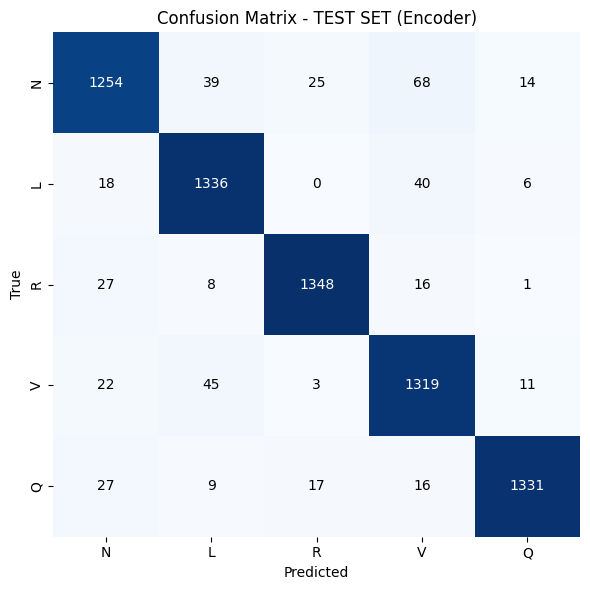

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Contoh matrix dari gambar Anda
cm = np.array([
    [1254,  39,  25,  68, 14],
    [  18, 1336,  0,  40,  6],
    [  27,   8, 1348, 16,  1],
    [  22,  45,  3, 1319, 11],
    [  27,   9, 17,  16, 1331]
])
labels = ['N', 'L', 'R', 'V', 'Q']

plt.figure(figsize=(6, 6))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                 xticklabels=labels, yticklabels=labels, cbar=False)

# Tambahkan angka secara manual agar bisa atur warnanya
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = "white" if i == j else "black"
        ax.text(j + 0.5, i + 0.5, f"{value}",
                ha='center', va='center',
                color=color, fontsize=10)

plt.title("Confusion Matrix - TEST SET (Encoder)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confmat_encoder_colored.png", dpi=300)
plt.show()